Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from scipy.stats import chi2_contingency 
import pandas as pd
from sklearn import metrics as sk
import seaborn as sns

Function definitions

In [ ]:
def get_lbp(img,neighbors,radius):  # returns lbp/texture image for given image
  return local_binary_pattern(img,neighbors,radius,'uniform') # Using Inbuilt function to calculate LBP

def get_hist(lbp,grid_x,grid_y,radius,neighbors): # returns appended hist from LBP
  box_width = lbp.shape[1]//grid_x  # calculate the width of the boxes/blocks
  box_height = lbp.shape[0]//grid_y # calculate the height of the boxes/blocks
  hist_counts=np.array([])          # list to store counts/freqs of appended hists

  for i in range(grid_y):     
    for j in range(grid_x):
      box = lbp[i*box_height:(i+1)*box_height,j*box_width:(j+1)*box_width]
      flat_box=box.ravel()
      counts,bins= np.histogram(flat_box, bins=range(0,(2**neighbors)+1))
      hist_counts = np.append(hist_counts, counts)
  return hist_counts

def get_lbp_hist(img,neighbors,radius,grid_x,grid_y): # direct function to get LBPH
  return get_hist(get_lbp(img,neighbors,radius),grid_x,grid_y,radius,neighbors)

def plot_hist(img_path):           # plots the appended/final hist for an image
  image=plt.imread(img_path,0)
  counts = list(get_lbp_hist(image,8,1,23,28))
  bins = range(0,1+len(counts))    # recalculate #bins from #counts
  plt.figure(figsize=(20,3))
  plt.hist(bins[:-1],bins,weights=counts)

def train_data(grid_x,grid_y,radius,neighbors): # sets up & returns the training data
  trained_hist = []
  for i in range(1,41):
    temp = np.empty((2**neighbors * grid_x * grid_y),dtype=np.float64)
    for j in range(1,8):
      path = '/content/drive/MyDrive/AT&T FACE DATASET/s' + str(i) + '/' + str(j) + '.pgm'
      image = plt.imread(path,0)
      temp += get_lbp_hist(image,neighbors,radius,grid_x,grid_y)
    trained_hist.append(temp/7)
  return list(zip([i for i in range(1,41)],trained_hist)),list(trained_hist)

def val_data(grid_x,grid_y,radius,neighbors):  # sets up & returns the val/test data
  val_hist = []
  labels = []
  for i in range(1,41):
    for j in range(8,11):
      path = '/content/drive/MyDrive/AT&T FACE DATASET/s' + str(i) + '/' + str(j) + '.pgm'
      image = plt.imread(path,0)
      hist = get_lbp_hist(image,neighbors,radius,grid_x,grid_y)
      val_hist.append(hist)
      labels.append(i)
  return list(zip(labels,val_hist)),list(val_hist)

def tfpn(label):                       # returns tp,tn,fp,fn for a given label
  index = label - 1                  
  tp = confusion[index,index]
  fp = sum(confusion[index,:]) - tp
  fn = sum(confusion[:,index]) - tp
  tn = sum(sum(confusion[:,:])) - tp - fp - fn
  return tp,fp,tn,fn

def stats(label,variation=''):         # returns various stats for given label
  tp,fp,tn,fn = tfpn(label)
  accuracy = (tp+tn)/(tp+tn+fp+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = (2*tp)/((2*tp)+fp+fn)
  if variation is 'all':
    return accuracy,precision,recall,f1,tp,fp,tn,fn
  else:
    return accuracy,precision,recall,f1

def comb_stats():                     # returns some overall stats  
  total_tp = sum([confusion[i,i] for i in range(len(confusion))])
  total = sum(sum(confusion[:,:]))
  micro_f1 = total_tp/total
  macro_f1 = sum([stats(i)[3] for i in range(len(confusion))])/len(confusion)
  return micro_f1,macro_f1

Setting up training and validation/testing data (label + histogram)

In [ ]:
trained_data,trained_hist = train_data(23,28,1,8)
validation_data,val_hist = val_data(23,28,1,8)

Example Image

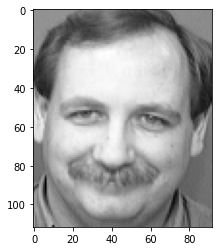

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/AT&T FACE DATASET/s25/7.pgm',0),cmap='gray')

Understanding LBP

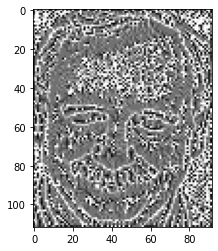

In [ ]:
plt.imshow(get_lbp(plt.imread('/content/drive/MyDrive/AT&T FACE DATASET/s25/7.pgm',0),8,1),cmap='gray')

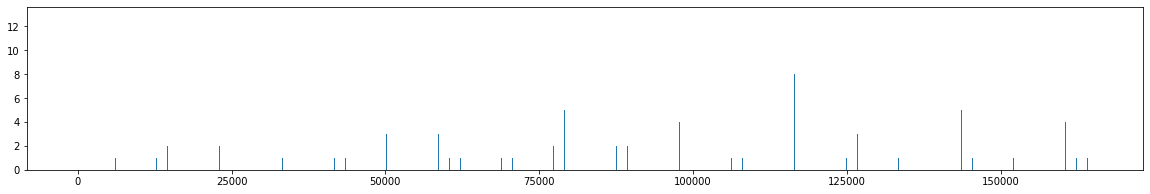

In [ ]:
plot_hist('/content/drive/MyDrive/AT&T FACE DATASET/s25/7.pgm')     #example histogram

Initiating the confusion matrix

In [ ]:
confusion = np.ndarray((40,40),dtype=np.int32) * 0;
for i in range(len(val_hist)):
  

Predicting label for validation/test images and updating confusion matrix

In [ ]:
actual = [l for l,h in validation_data]        # list of actual labels in val data
predicted = []                                 # list of predicted labels in val data
cum_accuracy=[]
for i in range(len(val_hist)):
  predicted.append(1 + np.argmin([chi2_contingency([[j+(10**-8) for j in val_hist[i]],[k+(10**-8) for k in t]])[0] for t in trained_hist]))
  confusion[predicted[i]-1][actual[i]-1] += 1  # update confusion matrix
  cum_accuracy.append(comb_stats()[0])        # update cumulative accuracy
diff=[m-n for m,n in zip(predicted,actual)]

Display confusion matrix

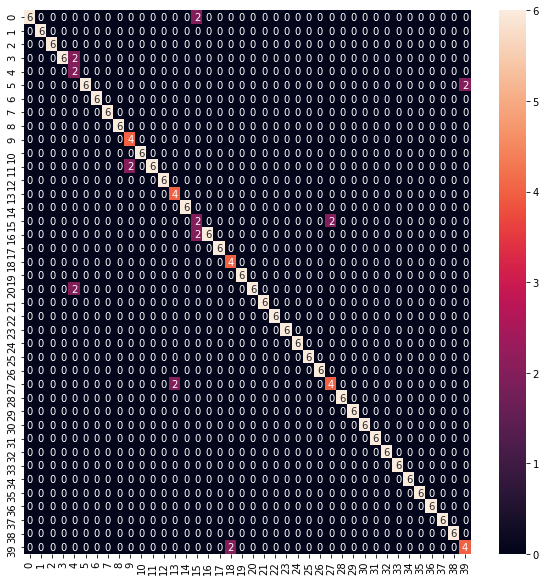

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion,annot=True)

Graph of prediction accuracy (Micro F-1) with iteration



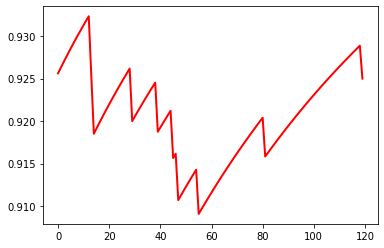

In [ ]:
plt.plot(cum_accuracy,color='red', linewidth=2)

In [ ]:
print("Micro F1 score is: " + (str) (comb_stats()[0]))
print("Macro F1 score is: " + (str) (comb_stats()[1]))

Micro F1 score is: 0.925
Macro F1 score is: 0.919404761904762


In [ ]:
n = range(40)
accuracy_x = []
precision_x = []
recall_x = []
f1_x = []
for i in n:
  accuracy_x.append(stats(i)[0])
  precision_x.append(stats(i)[1])
  recall_x.append(stats(i)[2])
  f1_x.append(stats(i)[3])

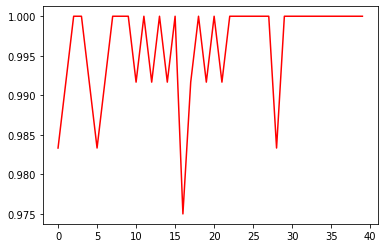

In [ ]:
plt.plot(n,accuracy_x,'r')

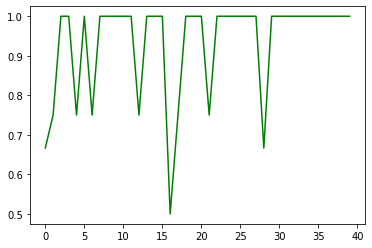

In [ ]:
plt.plot(n,precision_x,'g')

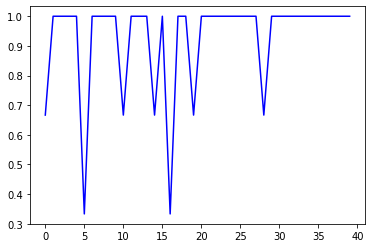

In [ ]:
plt.plot(n,recall_x,'b')

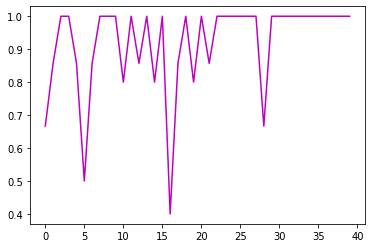

In [ ]:
plt.plot(n,f1_x,'m')